# Rank analysis

### Imports

In [1]:
import duckdb
import polars as pl
from pathlib import Path

In [2]:
database_name = 'database.duckdb'

In [3]:
db_path = Path('/in') / database_name


with duckdb.connect(str(db_path), read_only=True) as db:
    df = db.sql("FROM volumetric_water_content").pl()

df

tstamp,soil_moisture,meta_id
datetime[μs],f64,i16
2008-03-30 01:00:00,0.619,1
2008-05-17 23:00:00,0.2,1
2008-05-18 00:00:00,0.2,1
2008-05-18 01:00:00,0.2,1
2008-05-18 02:00:00,0.2,1
…,…,…
2010-03-31 05:00:00,0.271,178
2010-03-31 06:00:00,0.271,178
2010-03-31 07:00:00,0.271,178


In [4]:
long = df.pivot("meta_id", index="tstamp", values="soil_moisture")
long.head()

tstamp,1,2,3,4,5,6,7,8,18,19,20,21,22,23,24,25,26,41,42,43,44,45,46,47,48,49,64,65,66,67,68,69,70,71,72,87,…,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2008-03-30 01:00:00,0.619,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,0.595,0.486,0.377,0.365,null,null,null,null,null,null,null,null,0.574,null,0.432,0.388,null,null,null,null,null,0.264,0.404,0.234,0.284,0.248,0.354,0.347,0.352,0.392,0.321,0.426,0.52,0.288,0.465
2008-05-17 23:00:00,0.2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,0.287,0.202,0.269,0.32,null,null,null,null,null,null,null,null,0.267,null,0.329,0.361,null,null,null,null,null,0.084,0.131,0.109,0.14,0.11,0.264,0.187,0.222,0.233,0.299,0.144,0.208,0.119,0.173
2008-05-18 00:00:00,0.2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,0.296,0.206,0.271,0.319,null,null,null,null,null,null,null,null,0.263,null,0.328,0.352,null,null,null,null,null,0.174,0.138,0.145,0.21,0.115,0.266,0.189,0.221,0.234,0.304,0.144,0.207,0.119,0.173
2008-05-18 01:00:00,0.2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,0.286,0.206,0.268,0.33,null,null,null,null,null,null,null,null,0.263,null,0.327,0.351,null,null,null,null,null,0.198,0.147,0.203,0.216,0.121,0.305,0.232,0.245,0.267,0.34,0.144,0.207,0.119,0.173
2008-05-18 02:00:00,0.2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,0.285,0.199,0.271,0.329,null,null,null,null,null,null,null,null,0.263,null,0.328,0.352,null,null,null,null,null,0.203,0.151,0.214,0.221,0.128,0.306,0.237,0.246,0.272,0.344,0.144,0.207,0.119,0.173


In [5]:
# rank over timestep
ranks = df.with_columns(
    pl.col('soil_moisture').rank(method='average').over('tstamp').alias('rank')
)
ranked = ranks.pivot('meta_id', index='tstamp', values='rank')
ranked

tstamp,1,2,3,4,5,6,7,8,18,19,20,21,22,23,24,25,26,41,42,43,44,45,46,47,48,49,64,65,66,67,68,69,70,71,72,87,…,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2008-03-30 01:00:00,45.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,44.0,40.0,26.0,24.0,null,null,null,null,null,null,null,null,43.0,null,35.0,27.0,null,null,null,null,null,9.0,30.0,5.0,12.0,8.0,22.0,19.0,21.0,28.5,15.0,34.0,41.0,13.0,38.0
2008-05-17 23:00:00,19.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,35.0,20.0,32.0,37.5,null,null,null,null,null,null,null,null,30.0,null,40.0,44.0,null,null,null,null,null,5.0,10.0,7.0,11.0,8.0,29.0,18.0,23.0,25.0,36.0,12.0,22.0,9.0,16.0
2008-05-18 00:00:00,19.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,35.0,20.0,32.0,38.0,null,null,null,null,null,null,null,null,29.0,null,40.0,44.0,null,null,null,null,null,15.0,8.0,10.0,22.0,6.0,30.0,17.0,23.0,25.0,36.0,9.0,21.0,7.0,13.5
2008-05-18 01:00:00,17.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,34.0,19.0,31.0,39.0,null,null,null,null,null,null,null,null,27.0,null,38.0,44.0,null,null,null,null,null,15.5,9.0,18.0,21.0,7.0,35.0,23.0,25.0,30.0,41.0,8.0,20.0,6.0,13.0
2008-05-18 02:00:00,17.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,34.0,16.0,30.0,39.0,null,null,null,null,null,null,null,null,28.0,null,38.0,43.5,null,null,null,null,null,18.0,9.0,20.0,21.0,7.0,35.0,23.5,25.0,31.5,41.0,8.0,19.0,6.0,12.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2007-10-01 08:00:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2007-10-01 09:00:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2007-10-01 10:00:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [6]:

import altair as alt
alt.data_transformers.enable("vegafusion")


DataTransformerRegistry.enable('vegafusion')

In [ ]:
# chart = ranked.plot.line(x='tstamp').properties(width='container', height=600)

In [7]:
# DO NOT DO THIS; the plot gets 500MB large...
#chart = ranks.plot.line(x='tstamp', y='rank', color='meta_id').properties(width='container', height=400)

#chart.properties(height='container').save('/out/ranks.html')

In [13]:
pdf = ranked.to_pandas()
pdf.head()

,tstamp,1,2,3,4,5,6,7,8,18,...,169,170,171,172,173,174,175,176,177,178
0,2008-03-30 01:00:00,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,22.0,19.0,21.0,28.5,15.0,34.0,41.0,13.0,38.0
1,2008-05-17 23:00:00,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,29.0,18.0,23.0,25.0,36.0,12.0,22.0,9.0,16.0
2,2008-05-18 00:00:00,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,30.0,17.0,23.0,25.0,36.0,9.0,21.0,7.0,13.5
3,2008-05-18 01:00:00,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,35.0,23.0,25.0,30.0,41.0,8.0,20.0,6.0,13.0
4,2008-05-18 02:00:00,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,35.0,23.5,25.0,31.5,41.0,8.0,19.0,6.0,12.5


<Axes: xlabel='tstamp'>

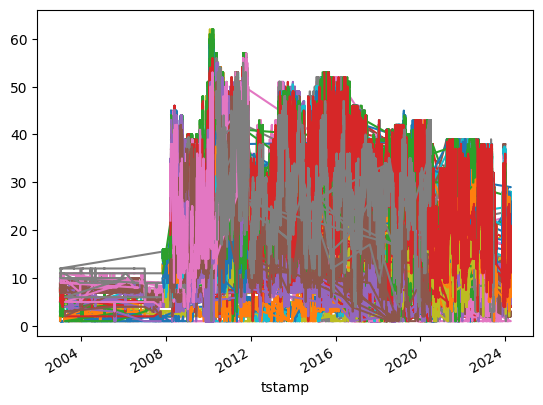

In [12]:
pdf.set_index('tstamp').plot(legend=False)